# Spotify Recommender System

Dataset: <https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?resource=download>

If you're working in Google Colab it will take a few minutes to upload this dataset. It will be faster if you're able to work in a local Jupyter notebook (By the way, VS Code can run notebooks. Try saving a file with the extension `.ipynb` and then open it in VS Code). 

You might want to subset this dataset to something like 100k rows right off of the bat so that it's easier to work with. You can do all of your modeling with the 100k row version and then once you've got things working the way you want them to you can run the notebook once with the entire dataset. 

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.neighbors import NearestNeighbors
from ast import literal_eval
import matplotlib.pyplot as plt
import joblib

In [9]:
tracks = pd.read_csv('tracks.csv')
artists = pd.read_csv('artists.csv')

## Tracks dataset includes:

- id
- name
- popularity
- duration_ms
- explicit
- artists
- id_artists
- release_date
- danceability
- energy
- key
- loudness
- mode
- speechiness
- acousticness
- instrumentalness
- liveness
- valence
- tempo
- time_signature

In [10]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


## Artists dataset includes:
- id
- followers
- genres
- name
- popularity

In [11]:
artists.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


## Cleanup


In [12]:
# make sure that there are no duplicates (there aren't any)
tracks = tracks.drop_duplicates()
artists = artists.drop_duplicates()

In [13]:
# turn strings of lists into actual lists
tracks['artists'] = tracks['artists'].apply(literal_eval)
tracks['id_artists'] = tracks['id_artists'].apply(literal_eval)

In [14]:
# make a year column
tracks['year'] = pd.to_datetime(tracks['release_date'], infer_datetime_format=True).dt.year

In [15]:
# tracks have multiple artists listed, we'll use the first artist mentioned
tracks['first_artist_id'] = tracks['id_artists'].apply(lambda x: x[0])

In [16]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,first_artist_id
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922,45tIt06XoI0Iio4LBEVpls
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922,14jtPCOoNZwquk5wd9DxrY
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922,5LiOoJbxVSAMkBS2fUm3X2
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922,5LiOoJbxVSAMkBS2fUm3X2
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922,3BiJGZsyX9sJchTqcSA7Su


In [17]:
# Turn genre stringified lists into actual lists
artists['genres'] = artists['genres'].apply(literal_eval)

In [18]:
artists.columns = ['artist_id', 'artist_followers', 'artist_genres', 'artist_name', 'artist_popularity']
artists.head()

,artist_id,artist_followers,artist_genres,artist_name,artist_popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [19]:
# inner merge the two dataframes on artist_id
df = pd.merge(artists, tracks, how='inner', left_on='artist_id', right_on="first_artist_id")

print(df.shape)
df.head()

(574812, 27)


,artist_id,artist_followers,artist_genres,artist_name,artist_popularity,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,first_artist_id
0,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,1YZkudiD6LfY5vmZKdOTyO,Roodade Ghame Ulfat Unse - Dialogues,5,46893,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.700,0.219,8,-11.896,1,0.4230,0.992,0.000000,0.178,0.539,106.112,1,1957,7DLDYPMRJ0NFPcBTlg04DE
1,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,36OG5Ep6IPA4Mj6TxoTpcw,Jab Ham Chale To Saya Bhi Apna - Dialogues,6,31013,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.439,0.311,1,-14.167,1,0.3270,0.960,0.243000,0.211,0.392,77.238,4,1957,7DLDYPMRJ0NFPcBTlg04DE
2,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,0JqKK01MXbnDhBKKdcUCnX,Teach Me Tonight,15,170667,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.357,0.185,7,-13.705,1,0.0309,0.802,0.000000,0.105,0.303,109.524,4,1955,1OCPhFtvkZDLUJJkrJfD2G
3,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2iKCL9YGGTpDPen0LhzcX2,Boom Boom Boomerang,8,136120,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.576,0.299,3,-10.515,1,0.0661,0.878,0.000009,0.409,0.983,201.395,3,1955,1OCPhFtvkZDLUJJkrJfD2G
4,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2fwms7R3b5N8aBnJ1CaltH,Snowbound for Christmas,1,180427,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.252,0.234,0,-10.615,1,0.0303,0.875,0.000000,0.371,0.295,95.664,4,1955,1OCPhFtvkZDLUJJkrJfD2G


In [20]:
# drop tracks that have null values (just one)
df = df.dropna()

print(df.shape)
df.head()

(574811, 27)


,artist_id,artist_followers,artist_genres,artist_name,artist_popularity,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,first_artist_id
0,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,1YZkudiD6LfY5vmZKdOTyO,Roodade Ghame Ulfat Unse - Dialogues,5,46893,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.700,0.219,8,-11.896,1,0.4230,0.992,0.000000,0.178,0.539,106.112,1,1957,7DLDYPMRJ0NFPcBTlg04DE
1,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,36OG5Ep6IPA4Mj6TxoTpcw,Jab Ham Chale To Saya Bhi Apna - Dialogues,6,31013,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.439,0.311,1,-14.167,1,0.3270,0.960,0.243000,0.211,0.392,77.238,4,1957,7DLDYPMRJ0NFPcBTlg04DE
2,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,0JqKK01MXbnDhBKKdcUCnX,Teach Me Tonight,15,170667,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.357,0.185,7,-13.705,1,0.0309,0.802,0.000000,0.105,0.303,109.524,4,1955,1OCPhFtvkZDLUJJkrJfD2G
3,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2iKCL9YGGTpDPen0LhzcX2,Boom Boom Boomerang,8,136120,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.576,0.299,3,-10.515,1,0.0661,0.878,0.000009,0.409,0.983,201.395,3,1955,1OCPhFtvkZDLUJJkrJfD2G
4,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2fwms7R3b5N8aBnJ1CaltH,Snowbound for Christmas,1,180427,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.252,0.234,0,-10.615,1,0.0303,0.875,0.000000,0.371,0.295,95.664,4,1955,1OCPhFtvkZDLUJJkrJfD2G


## Exploratory Data Analysis

Some graphs.

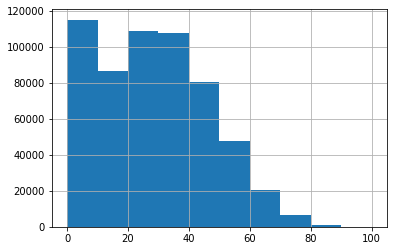

In [21]:
df['popularity'].hist();

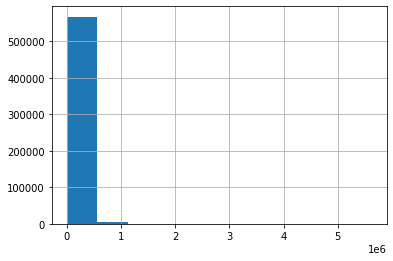

In [22]:
# definitely some outliers in terms of duration
df['duration_ms'].hist();

In [23]:
# the longest track is ~ 93 minutes long...
df['duration_ms'].max() / 1000 / 60

93.68696666666666

In [24]:
# Summary statistics of duration (in seconds)
(df['duration_ms'] / 1000).describe()

count    574811.000000
mean        229.849679
std         122.116153
min           3.344000
25%         175.373000
50%         215.000000
75%         263.867000
max        5621.218000
Name: duration_ms, dtype: float64

In [25]:
# 4.4% of songs are explicit
df['explicit'].value_counts(normalize=True)*100

0    95.608122
1     4.391878
Name: explicit, dtype: float64

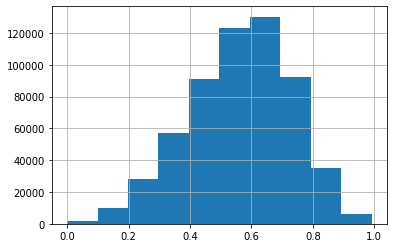

In [26]:
# normalized between 0 and 1
df['danceability'].hist();

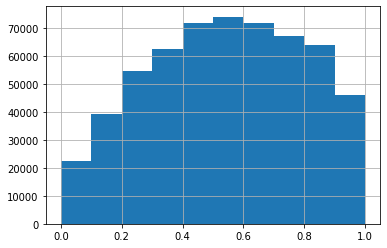

In [27]:
# normalized between 0 and 1
df['energy'].hist();

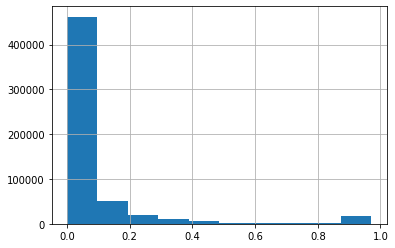

In [28]:
# normalized between 0 and 1
# I wonder if the very speechy ones are podcasts or something?
df['speechiness'].hist();

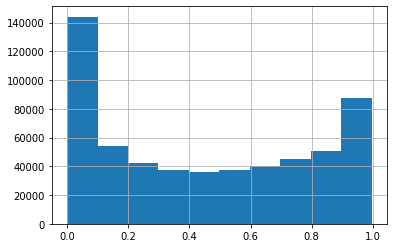

In [29]:
# normalized between 0 and 1
df['acousticness'].hist();

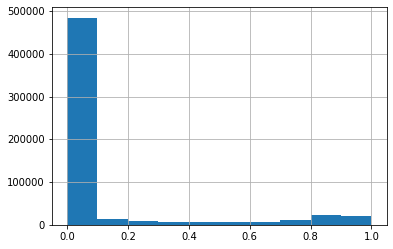

In [30]:
# normalized between 0 and 1
tracks['instrumentalness'].hist();

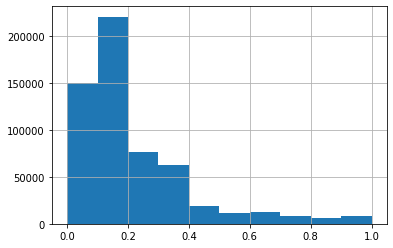

In [31]:
# normalized between 0 and 1
df['liveness'].hist();

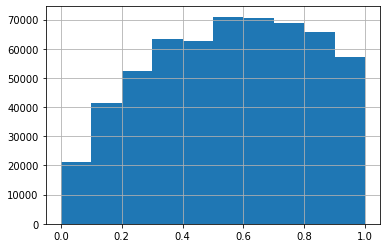

In [32]:
# normalized between 0 and 1
df['valence'].hist();

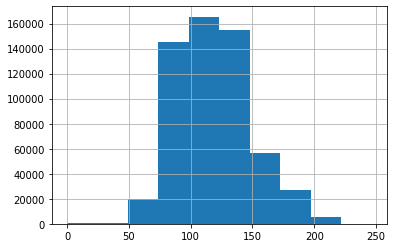

In [33]:
# Measured in BPM (beats per minute)
df['tempo'].hist();

In [34]:
# percentage of time signatures
df['time_signature'].value_counts(normalize=True)*100

4    85.856742
3    11.031278
5     1.940638
1     1.124370
0     0.046972
Name: time_signature, dtype: float64

In [35]:
# Major vs Minor key?
df['mode'].value_counts(normalize=True)*100

1    65.92132
0    34.07868
Name: mode, dtype: float64

In [36]:
df['key'].value_counts(normalize=True).sort_index()*100

0     12.759324
1      7.096767
2     11.362865
3      3.677209
4      8.235229
5      9.150834
6      5.260686
7     12.580483
8      5.696481
9     11.105737
10     6.406454
11     6.667931
Name: key, dtype: float64

## Training a NearestNeighbors on only track-level numeric features and artist genre:

In [37]:
df.head()

,artist_id,artist_followers,artist_genres,artist_name,artist_popularity,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,first_artist_id
0,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,1YZkudiD6LfY5vmZKdOTyO,Roodade Ghame Ulfat Unse - Dialogues,5,46893,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.700,0.219,8,-11.896,1,0.4230,0.992,0.000000,0.178,0.539,106.112,1,1957,7DLDYPMRJ0NFPcBTlg04DE
1,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,36OG5Ep6IPA4Mj6TxoTpcw,Jab Ham Chale To Saya Bhi Apna - Dialogues,6,31013,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.439,0.311,1,-14.167,1,0.3270,0.960,0.243000,0.211,0.392,77.238,4,1957,7DLDYPMRJ0NFPcBTlg04DE
2,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,0JqKK01MXbnDhBKKdcUCnX,Teach Me Tonight,15,170667,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.357,0.185,7,-13.705,1,0.0309,0.802,0.000000,0.105,0.303,109.524,4,1955,1OCPhFtvkZDLUJJkrJfD2G
3,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2iKCL9YGGTpDPen0LhzcX2,Boom Boom Boomerang,8,136120,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.576,0.299,3,-10.515,1,0.0661,0.878,0.000009,0.409,0.983,201.395,3,1955,1OCPhFtvkZDLUJJkrJfD2G
4,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2fwms7R3b5N8aBnJ1CaltH,Snowbound for Christmas,1,180427,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.252,0.234,0,-10.615,1,0.0303,0.875,0.000000,0.371,0.295,95.664,4,1955,1OCPhFtvkZDLUJJkrJfD2G


## TFIDF of Genres

We will combine all genres into a single document and then use TF-IDF vectorization to create a numeric representation of the words used to describe the genre. (You'll learn more about this technique in sprint 13!)

In [38]:
# combine genre strings into one big string (document) per track
df['genre_doc'] = df['artist_genres'].apply(lambda x: " ".join(x))

df.head()

,artist_id,artist_followers,artist_genres,artist_name,artist_popularity,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,first_artist_id,genre_doc
0,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,1YZkudiD6LfY5vmZKdOTyO,Roodade Ghame Ulfat Unse - Dialogues,5,46893,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.700,0.219,8,-11.896,1,0.4230,0.992,0.000000,0.178,0.539,106.112,1,1957,7DLDYPMRJ0NFPcBTlg04DE,
1,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,36OG5Ep6IPA4Mj6TxoTpcw,Jab Ham Chale To Saya Bhi Apna - Dialogues,6,31013,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.439,0.311,1,-14.167,1,0.3270,0.960,0.243000,0.211,0.392,77.238,4,1957,7DLDYPMRJ0NFPcBTlg04DE,
2,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,0JqKK01MXbnDhBKKdcUCnX,Teach Me Tonight,15,170667,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.357,0.185,7,-13.705,1,0.0309,0.802,0.000000,0.105,0.303,109.524,4,1955,1OCPhFtvkZDLUJJkrJfD2G,
3,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2iKCL9YGGTpDPen0LhzcX2,Boom Boom Boomerang,8,136120,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.576,0.299,3,-10.515,1,0.0661,0.878,0.000009,0.409,0.983,201.395,3,1955,1OCPhFtvkZDLUJJkrJfD2G,
4,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2fwms7R3b5N8aBnJ1CaltH,Snowbound for Christmas,1,180427,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.252,0.234,0,-10.615,1,0.0303,0.875,0.000000,0.371,0.295,95.664,4,1955,1OCPhFtvkZDLUJJkrJfD2G,


### Create Document-Term Matrix of Genre Tokens

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
# We're only using th 100 most common tokens so that our datafrmae doesn't 
# exceed the amount of ram provided by Google Colab
# you can increase the max_features parameter if working locally
vect = TfidfVectorizer(stop_words='english', lowercase=True, max_features=100)

dtm = vect.fit_transform(df['genre_doc'])

dtm = pd.DataFrame(data=dtm.todense(), columns=vect.get_feature_names_out())

print(dtm.shape)
dtm.head()

(574811, 100)


,adult,album,alternative,argentine,art,band,blues,bollywood,brazilian,brill,british,building,canadian,cantopop,classic,classical,contemporary,cool,country,cumbia,czech,dance,danish,desi,disco,dutch,early,easy,en,era,espanol,filmi,finnish,folk,french,funk,german,gold,greek,hard,hip,hoerspiel,hop,house,icelandic,indie,indonesian,israeli,italian,japanese,jazz,latin,listening,lounge,mandopop,mellow,metal,mexican,modern,mpb,musica,new,norwegian,nova,permanent,polish,pop,post,progressive,psychedelic,punk,ranchera,rap,reggae,regional,rock,roll,romantic,roots,russian,salsa,sertanejo,singer,soft,songwriter,soul,spanish,standards,sufi,swedish,swing,thai,trance,trap,tropical,turkish,uk,vintage,vocal,wave
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create X Matrix of numeric song attributes combined with Document-Term Matrix

In [42]:
numeric_columns = ['popularity', 'duration_ms', 'explicit', 'danceability', 
                  'energy', 'key', 'loudness', 'mode', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 
                  'tempo', 'time_signature', 'year', ]

X = pd.concat([df[numeric_columns].reset_index(drop=True), dtm.reset_index(drop=True)], axis=1)

print(X.shape)
X.head()

(574811, 116)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,adult,album,alternative,argentine,art,band,blues,bollywood,brazilian,brill,british,building,canadian,cantopop,classic,classical,contemporary,cool,country,cumbia,czech,dance,danish,desi,disco,dutch,early,easy,en,era,espanol,filmi,finnish,folk,french,funk,german,gold,greek,hard,hip,hoerspiel,hop,house,icelandic,indie,indonesian,israeli,italian,japanese,jazz,latin,listening,lounge,mandopop,mellow,metal,mexican,modern,mpb,musica,new,norwegian,nova,permanent,polish,pop,post,progressive,psychedelic,punk,ranchera,rap,reggae,regional,rock,roll,romantic,roots,russian,salsa,sertanejo,singer,soft,songwriter,soul,spanish,standards,sufi,swedish,swing,thai,trance,trap,tropical,turkish,uk,vintage,vocal,wave
0,5,46893,0,0.700,0.219,8,-11.896,1,0.4230,0.992,0.000000,0.178,0.539,106.112,1,1957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,31013,0,0.439,0.311,1,-14.167,1,0.3270,0.960,0.243000,0.211,0.392,77.238,4,1957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,170667,0,0.357,0.185,7,-13.705,1,0.0309,0.802,0.000000,0.105,0.303,109.524,4,1955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,136120,0,0.576,0.299,3,-10.515,1,0.0661,0.878,0.000009,0.409,0.983,201.395,3,1955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,180427,0,0.252,0.234,0,-10.615,1,0.0303,0.875,0.000000,0.371,0.295,95.664,4,1955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Use Nearest Neighbors to get 5 similar songs.

Remember, that our dataset is still missing a lot of important features such as the spoken language of any lyrics as well as the lyrics themselves. Our model is blind to this context. 

Our model will only be able to match songs based on the general characteristics of the music and the genre of the song. When evaluating the model, try and judge only the overall vibe, pace, intensity, etc. of the recommendations. We need to do lots more feature engineering in order to make really great recommendations, but I hope this basic serves as viable proof of concept.



In [43]:
neigh = NearestNeighbors(n_neighbors=5, n_jobs=-1)
neigh.fit(X)

NearestNeighbors(n_jobs=-1)

In [44]:
track_name = "Hello, Dolly!"

# Get index of first song that matches the song title exactly
track_index = df[df['name'] == track_name].index[0]

# Look at potential selected track
df[df['name'] == track_name].iloc[0]

artist_id                                      3DKPVHC4GzISLpUdAapGiZ
artist_followers                                               6629.0
artist_genres                                                      []
artist_name                                            Carol Channing
artist_popularity                                                  24
id                                             7vvnz6fQL16iWA0X8WDWy8
name                                                    Hello, Dolly!
popularity                                                         19
duration_ms                                                    342533
explicit                                                            0
artists                      [Carol Channing, Hello, Dolly! Ensemble]
id_artists           [3DKPVHC4GzISLpUdAapGiZ, 7wVM3hybnRXz1aY0u1hdAY]
release_date                                                     1964
danceability                                                    0.397
energy              

In [45]:
distances, song_indices = neigh.kneighbors(X.iloc[track_index].values.reshape(1,-1), 6)

song_indices[0]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


array([227368, 405153, 321514, 408092, 421700,  37214])

In [46]:
def open_in_browser(song_indices):
    for index in song_indices:
        song = df.iloc[index]
        name = song['name']
        artist = song['artist_name']
        id = song['id']
        print(f'{name} by {artist} - https://open.spotify.com/track/{id}')

open_in_browser(song_indices[0])

Hello, Dolly! by Carol Channing - https://open.spotify.com/track/7vvnz6fQL16iWA0X8WDWy8
I Don't Even Know Myself - Live by The Who - https://open.spotify.com/track/48qS2iZ7DsLqR26RddDxUe
There'll Never Be Another You by Sonny Rollins - https://open.spotify.com/track/4FVkDTHzohvkruGSKg4qh6
Gori Ke Haath Mein by Mohammed Rafi - https://open.spotify.com/track/6WxBaUvymTAkze4tQ8aJli
The Greatest Love of All - Live by George Benson - https://open.spotify.com/track/4MPm1bsUsZCyJpmAbwPa6H
Bohu Rati Hol Jana by Jitul Sonowal - https://open.spotify.com/track/4tXtmYTobs6TTtuNlWA7Ow


## Export the Vectorizer and NearestNeighbors models

In [47]:
# Export our TF-IDF Vectorizer to a file
joblib.dump(vect, 'vect.pkl')

['vect.pkl']

### Trouble downloading the `neigh.pkl` file?

If Google Colab will not allow you to download the neigh.pkl file giving you a "failed to fetch" error. You will need to allow third party cookies from `colab.research.google.com` before you can download this file.

Visit: `chrome://settings/cookies?search=cookies` 

and add `colab.research.google.com` to the "sites that can always use cookies" section and make sure to check the box to "Include third party cookies on this site"

Once you have done this you will be able to successfully download this file. However, you shouldn't *need* to download this file becausea version of it it has already been provided in the both the starter and solution repositories.

In [48]:
# Export our NearestNeighbors to a file
# Using compression here is essential or else the file will take
# 30 minutes or more to download.
joblib.dump(neigh, 'neigh.pkl', compress=3)

['neigh.pkl']